# PyMC model

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import mean_squared_error
from scipy.stats import halfnorm
import math
from statsmodels.formula.api import glm
import statsmodels.api as sm
import seaborn as sns

from scipy import stats
from scipy.special import expit as logistic

In [4]:
from pyBasket.common import load_obj
from pyBasket.model import get_model_simple_bern, get_model_hierarchical_bern
from pyBasket.model import get_model_pyBasket, get_model_pyBasket_nc
from pyBasket.synthetic_data import generate_pyBasket_data

## 1. Generate some data

In [5]:
np.random.seed(42)

New generative process

In [6]:
results = generate_pyBasket_data()    
data_df = results['data_df']
true_basket_p = results['true_basket_p']
true_cluster_p = results['true_cluster_p']
true_mat = results['true_mat']
n_tissues = results['n_tissues']
n_clusters = results['n_clusters']

In [7]:
data_df

,basket_number,cluster_number,responsive
0,6,6,0
1,19,3,1
2,14,0,0
3,10,4,1
4,7,6,0
...,...,...,...
495,4,8,0
496,11,4,0
497,15,2,0
498,15,4,0


In [8]:
true_basket_df = pd.DataFrame({'prob': true_basket_p, 'basket': range(len(true_basket_p))})

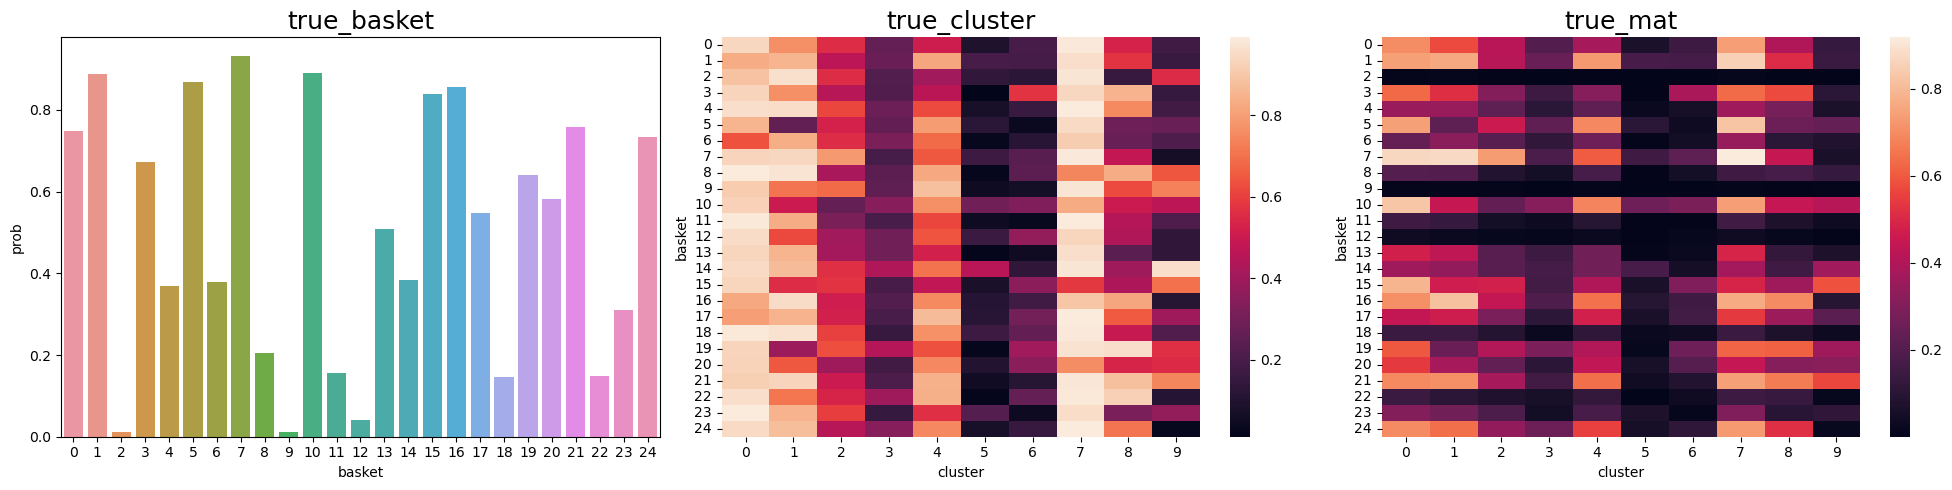

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

sns.barplot(data=true_basket_df, x='basket', y='prob', ax=ax1)
sns.heatmap(true_cluster_p, ax=ax2)
sns.heatmap(true_mat, ax=ax3)

ax1.set_title('true_basket', fontsize=18)
ax2.set_title('true_cluster', fontsize=18)
ax2.set_xlabel('cluster')
ax2.set_ylabel('basket')
ax3.set_title('true_mat', fontsize=18)
ax3.set_xlabel('cluster')
ax3.set_ylabel('basket')
plt.tight_layout()

## 2. Define models

No. of samples to collect before and after burn-in during MCMC.

In [10]:
n_burn_in = int(5E3)
n_sample = int(5E3)
target_accept = 0.99

### Simple model

In [11]:
model_s = get_model_simple_bern(data_df, n_tissues, n_clusters)

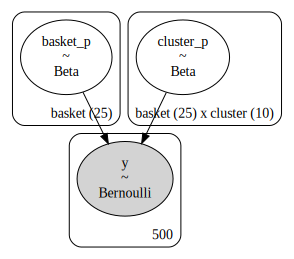

In [12]:
pm.model_to_graphviz(model_s)

In [13]:
with model_s:
    trace_s = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basket_p, cluster_p]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 163 seconds.


In [14]:
az.summary(trace_s).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
basket_p[0],0.71,0.16,0.46,1.00,0.0,0.0,18128.0,11471.0,1.0
basket_p[1],0.89,0.09,0.71,1.00,0.0,0.0,22301.0,11815.0,1.0
basket_p[2],0.07,0.07,0.00,0.20,0.0,0.0,27572.0,12502.0,1.0
basket_p[3],0.68,0.18,0.40,1.00,0.0,0.0,23525.0,9766.0,1.0
basket_p[4],0.19,0.13,0.00,0.42,0.0,0.0,33410.0,12740.0,1.0
...,...,...,...,...,...,...,...,...,...
"cluster_p[24, 5]",0.35,0.26,0.00,0.84,0.0,0.0,34548.0,12020.0,1.0
"cluster_p[24, 6]",0.41,0.27,0.00,0.89,0.0,0.0,44660.0,12392.0,1.0
"cluster_p[24, 7]",0.67,0.24,0.25,1.00,0.0,0.0,40111.0,11553.0,1.0
"cluster_p[24, 8]",0.42,0.24,0.04,0.86,0.0,0.0,32742.0,11625.0,1.0


In [15]:
# az.plot_ess(
#     trace_s, kind="evolution", var_names=['basket_p', 'cluster_p']
# )

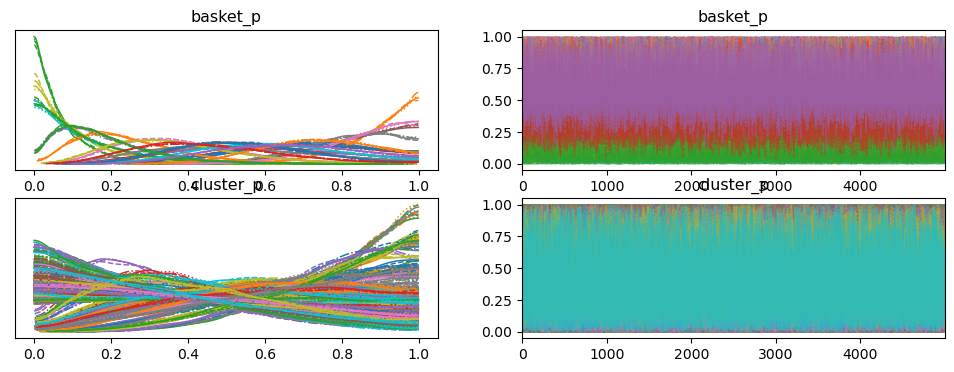

In [16]:
az.plot_trace(trace_s, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

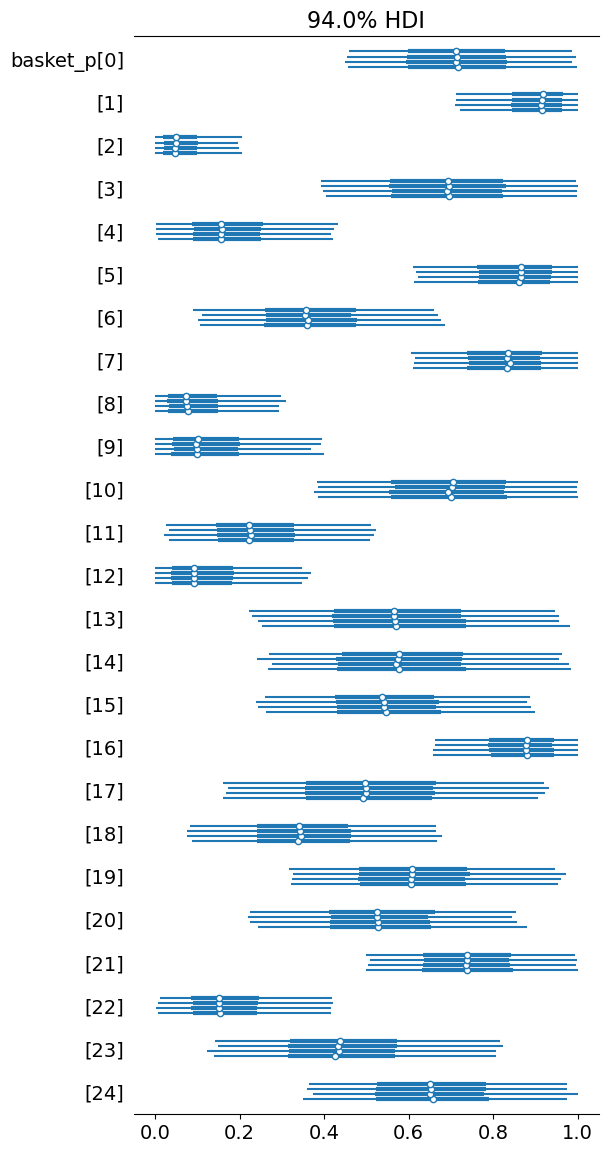

In [17]:
az.plot_forest(trace_s, var_names=['basket_p'])

In [18]:
stacked_s = az.extract(trace_s)

In [19]:
inferred_basket_p = np.mean(stacked_s.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.11731898664062725)

In [20]:
inferred_cluster_p = np.mean(stacked_s.cluster_p.values, axis=2)
true_cluster_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

((25, 10), (25, 10), 0.28946373509583856)

In [21]:
inferred_basket_p_tiled = np.tile(inferred_basket_p, (n_clusters, 1)).T
inferred_mat_s = inferred_basket_p_tiled * inferred_cluster_p
true_mat.shape, inferred_basket_p_tiled.shape, inferred_mat_s.shape

((25, 10), (25, 10), (25, 10))

### Hierarchical model

We extend the simple model by adding prior Beta distributions on basket_p and cluster_p, which come from Beta distribution themselves.

This hierarchical model suffers from a lot of divergences. It's difficult to re-parameterise this since there's no conjugate prior, so not sure how to fix it. See:
- https://discourse.pymc.io/t/non-centered-parameterization-of-a-beta-distribution/6872/7
- https://stats.stackexchange.com/questions/67443/does-the-beta-distribution-have-a-conjugate-prior

In [22]:
model_h1 = get_model_hierarchical_bern(data_df, n_tissues, n_clusters)

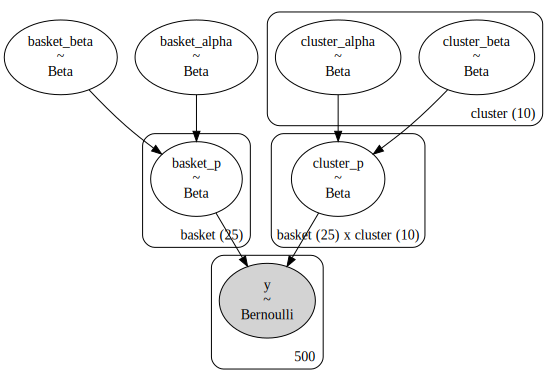

In [23]:
pm.model_to_graphviz(model_h1)

In [24]:
with model_h1:
    trace_h1 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basket_alpha, basket_beta, cluster_alpha, cluster_beta, basket_p, cluster_p]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 1363 seconds.
There were 2224 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1974 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2144 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2047 divergences after tuning. Increase `target_accept` or reparameterize.


In [25]:
az.summary(trace_h1).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
basket_alpha,0.71,0.16,0.45,1.00,0.00,0.0,4933.0,5282.0,1.00
basket_beta,0.79,0.15,0.52,1.00,0.00,0.0,3821.0,5774.0,1.00
cluster_alpha[0],0.76,0.18,0.42,1.00,0.00,0.0,3436.0,4139.0,1.00
cluster_alpha[1],0.74,0.19,0.40,1.00,0.00,0.0,5301.0,6016.0,1.00
cluster_alpha[2],0.65,0.22,0.27,1.00,0.01,0.0,1599.0,1265.0,1.00
...,...,...,...,...,...,...,...,...,...
"cluster_p[24, 5]",0.14,0.23,0.00,0.66,0.00,0.0,1108.0,846.0,1.01
"cluster_p[24, 6]",0.28,0.31,0.00,0.91,0.00,0.0,1809.0,1256.0,1.00
"cluster_p[24, 7]",0.91,0.17,0.56,1.00,0.00,0.0,2932.0,2305.0,1.00
"cluster_p[24, 8]",0.51,0.29,0.10,1.00,0.00,0.0,4004.0,2173.0,1.00


In [26]:
# az.plot_ess(
#     trace_h1, kind="evolution", var_names=['basket_p', 'cluster_p']
# )

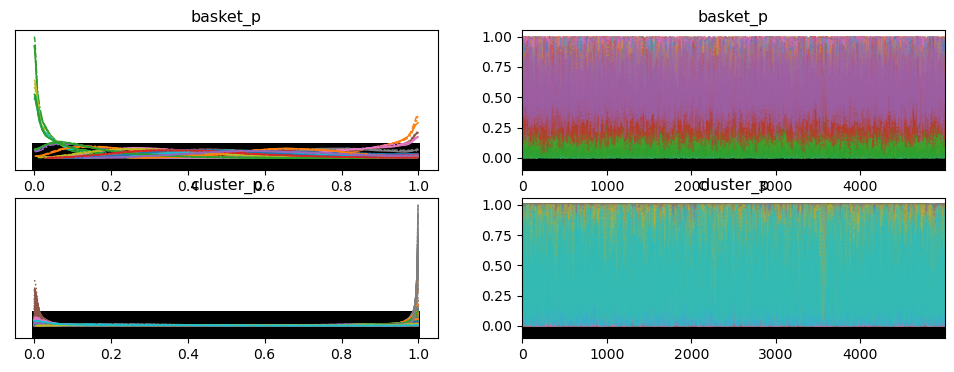

In [27]:
az.plot_trace(trace_h1, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

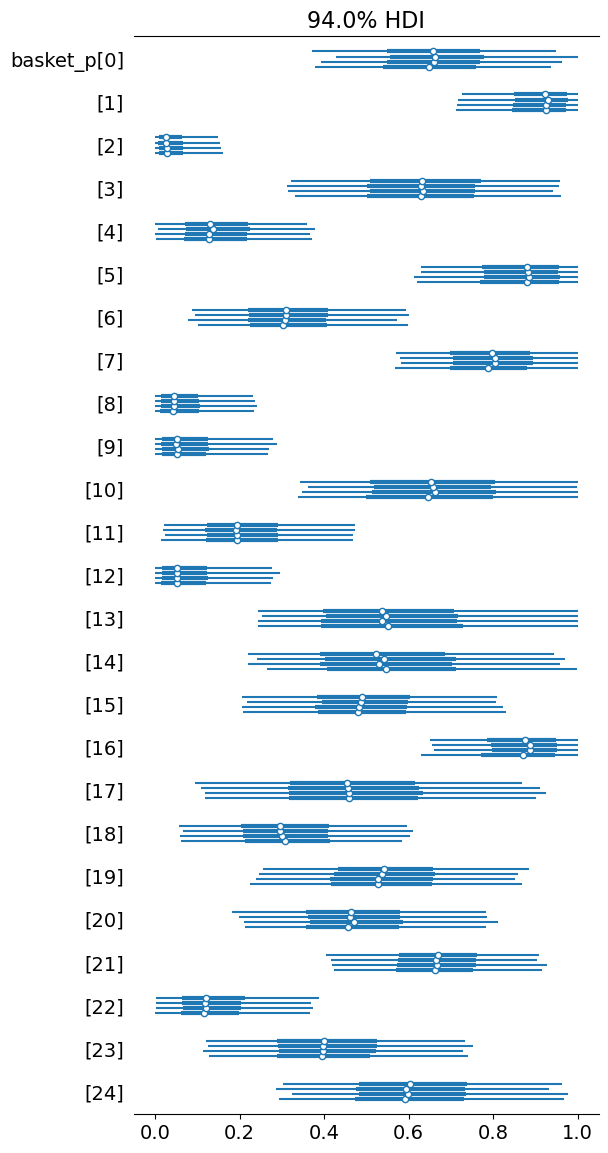

In [28]:
az.plot_forest(trace_h1, var_names=['basket_p'])

In [29]:
stacked_h1 = az.extract(trace_h1)

In [30]:
inferred_basket_p = np.mean(stacked_h1.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.12668866502546205)

In [31]:
inferred_cluster_p = np.mean(stacked_h1.cluster_p.values, axis=2)
true_cluster_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

((25, 10), (25, 10), 0.2189672308653013)

In [32]:
inferred_basket_p_tiled = np.tile(inferred_basket_p, (n_clusters, 1)).T
inferred_mat_h1 = inferred_basket_p_tiled * inferred_cluster_p
true_mat.shape, inferred_basket_p_tiled.shape, inferred_mat_s.shape

((25, 10), (25, 10), (25, 10))

### pyBasket model

Another hierarchical model, but here we model the log-odds instead, so we can set Normal prior distributions on the parameters.

This is the model described in the paper, and it's what we shall use for further analysis.

In [33]:
model_h2 = get_model_pyBasket(data_df, n_tissues, n_clusters)

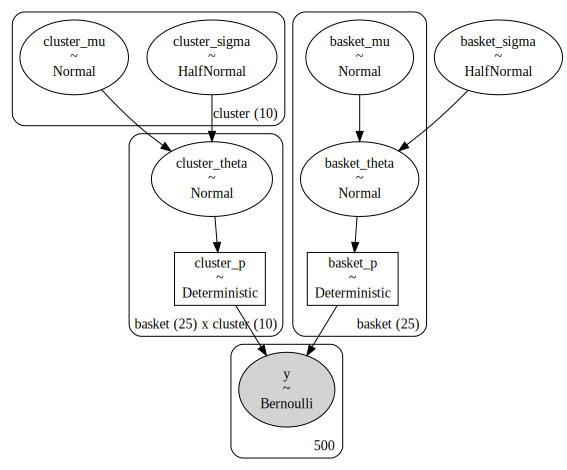

In [34]:
pm.model_to_graphviz(model_h2)

In [35]:
# with model_h2:
#     trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

This is the one we actually use after reparameterisation.

In [36]:
model_h2_nc = get_model_pyBasket_nc(data_df, n_tissues, n_clusters)

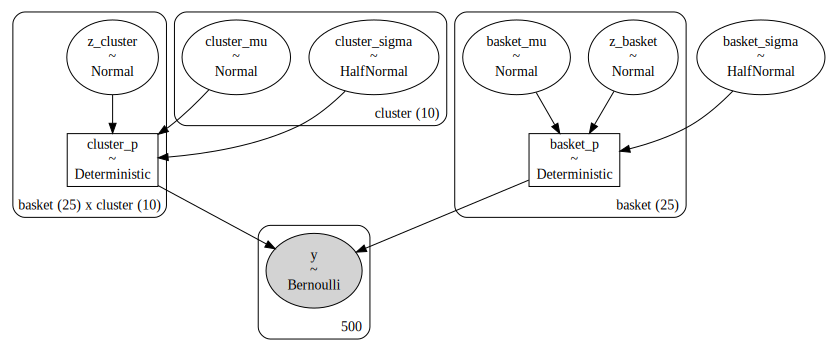

In [37]:
pm.model_to_graphviz(model_h2_nc)

In [38]:
with model_h2_nc:
    trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_basket, z_cluster, basket_mu, cluster_mu, basket_sigma, cluster_sigma]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 255 seconds.


In [39]:
az.summary(trace_h2).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_basket[0],0.19,0.95,-1.67,1.96,0.01,0.01,20426.0,15180.0,1.0
z_basket[1],0.39,0.98,-1.46,2.23,0.01,0.01,18916.0,15962.0,1.0
z_basket[2],-0.47,0.99,-2.32,1.42,0.01,0.01,14921.0,14259.0,1.0
z_basket[3],0.12,0.96,-1.68,1.92,0.01,0.01,24618.0,15866.0,1.0
z_basket[4],-0.28,0.95,-2.00,1.55,0.01,0.01,20788.0,14673.0,1.0
...,...,...,...,...,...,...,...,...,...
"cluster_p[24, 5]",0.16,0.12,0.00,0.38,0.00,0.00,25999.0,15946.0,1.0
"cluster_p[24, 6]",0.26,0.17,0.00,0.56,0.00,0.00,25354.0,15560.0,1.0
"cluster_p[24, 7]",0.91,0.09,0.75,1.00,0.00,0.00,20958.0,15336.0,1.0
"cluster_p[24, 8]",0.57,0.20,0.20,0.95,0.00,0.00,14195.0,10860.0,1.0


In [40]:
# az.plot_ess(
#     trace_h2, kind="evolution", var_names=['basket_p', 'cluster_p']
# )

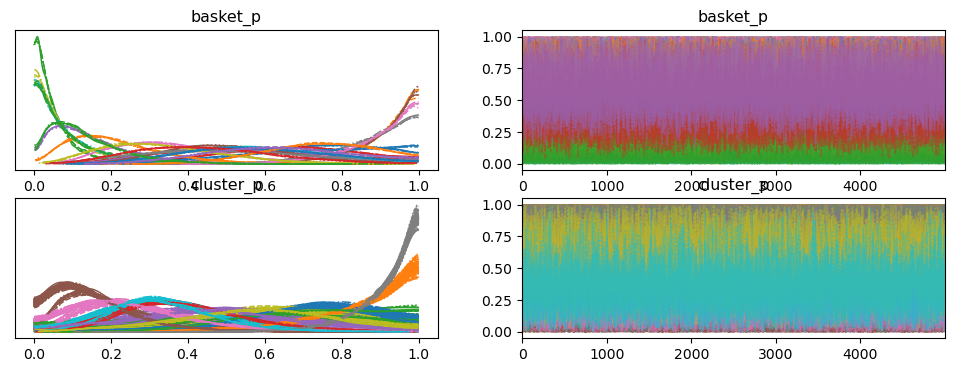

In [41]:
az.plot_trace(trace_h2, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

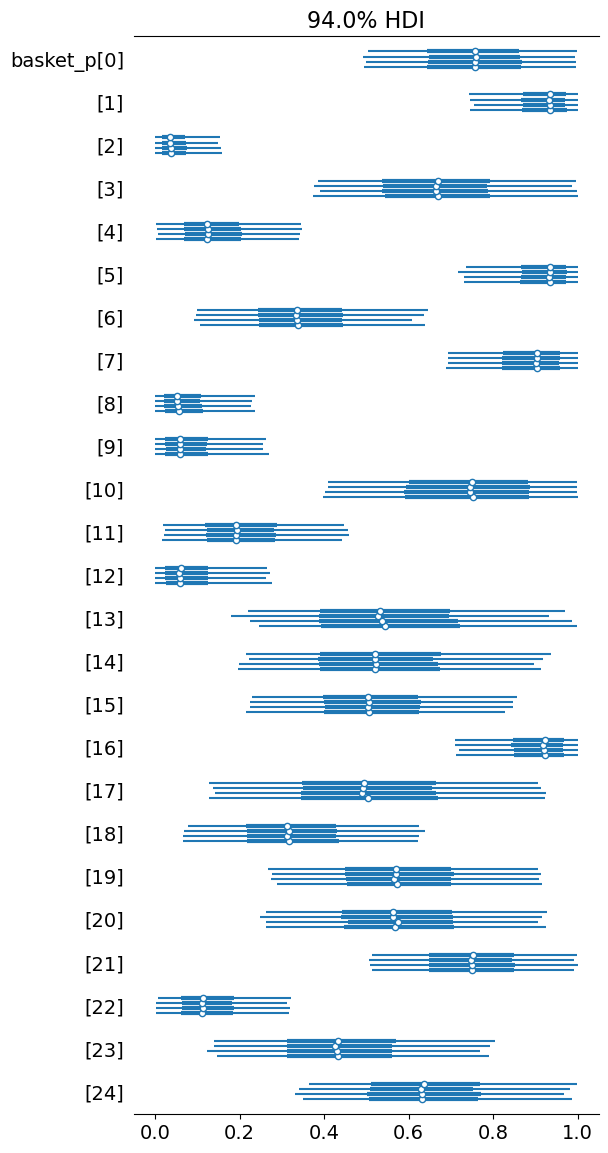

In [42]:
az.plot_forest(trace_h2, var_names=['basket_p'])

In [43]:
stacked_h2 = az.extract(trace_h2)

In [44]:
inferred_basket_p = np.mean(stacked_h2.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.1110935819213295)

In [45]:
inferred_cluster_p = np.mean(stacked_h2.cluster_p.values, axis=2)
true_cluster_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

((25, 10), (25, 10), 0.18589216204013495)

In [46]:
inferred_basket_p_tiled = np.tile(inferred_basket_p, (n_clusters, 1)).T
inferred_mat_h2 = inferred_basket_p_tiled * inferred_cluster_p
true_mat.shape, inferred_basket_p_tiled.shape, inferred_mat_s.shape

((25, 10), (25, 10), (25, 10))

## 3. Calculate RMSE

Calculate root mean squared error for basket_p

In [47]:
actual = true_basket_p

predicted_basket_s = np.mean(stacked_s.basket_p.values, axis=1)
predicted_basket_s_df = pd.DataFrame({'prob': predicted_basket_s, 'basket': range(len(predicted_basket_s))})
rmse_s = math.sqrt(mean_squared_error(actual, predicted_basket_s))

predicted_basket_h1 = np.mean(stacked_h1.basket_p.values, axis=1)
predicted_basket_h1_df = pd.DataFrame({'prob': predicted_basket_h1, 'basket': range(len(predicted_basket_h1))})
rmse_h1 = math.sqrt(mean_squared_error(actual, predicted_basket_h1))

predicted_basket_h2 = np.mean(stacked_h2.basket_p.values, axis=1)
predicted_basket_h2_df = pd.DataFrame({'prob': predicted_basket_h2, 'basket': range(len(predicted_basket_h2))})
rmse_h2 = math.sqrt(mean_squared_error(actual, predicted_basket_h2))

rmse_basket_p = pd.DataFrame({
    'method': ['simple', 'hierarchical', 'pyBasket'],
    'RMSE': [rmse_s, rmse_h1, rmse_h2]
})
rmse_basket_p

,method,RMSE
0,simple,0.117319
1,hierarchical,0.126689
2,pyBasket,0.111094


Calculate root mean squared error for cluster_p

In [48]:
actual = true_cluster_p

predicted_cluster_s = np.mean(stacked_s.cluster_p.values, axis=2)
rmse_s = math.sqrt(mean_squared_error(actual, predicted_cluster_s))

predicted_cluster_h1 = np.mean(stacked_h1.cluster_p.values, axis=2)
rmse_h1 = math.sqrt(mean_squared_error(actual, predicted_cluster_h1))

predicted_cluster_h2 = np.mean(stacked_h2.cluster_p.values, axis=2)
rmse_h2 = math.sqrt(mean_squared_error(actual, predicted_cluster_h2))

rmse_cluster_p = pd.DataFrame({
    'method': ['simple', 'hierarchical', 'pyBasket'],
    'RMSE': [rmse_s, rmse_h1, rmse_h2]
})
rmse_cluster_p

,method,RMSE
0,simple,0.289464
1,hierarchical,0.218967
2,pyBasket,0.185892


Make plot

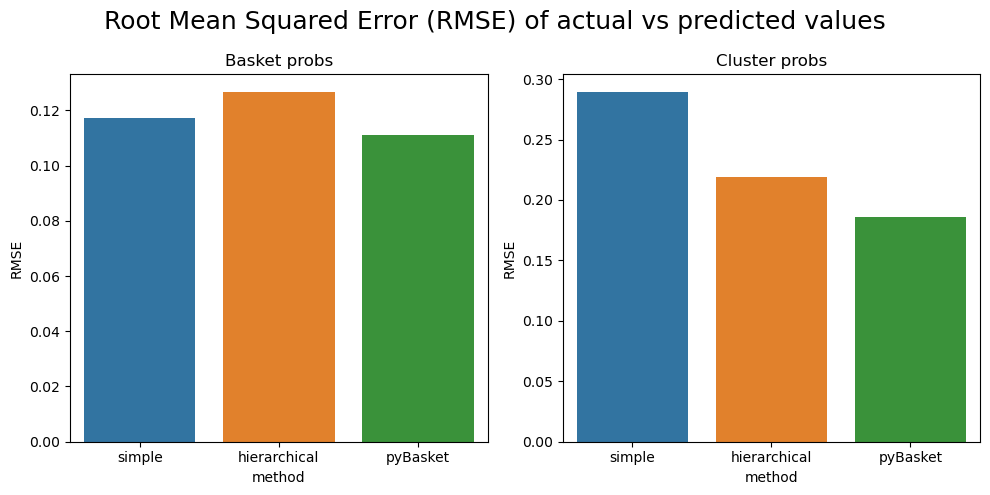

In [49]:
methods = rmse_basket_p['method'].unique()
colors = sns.color_palette("deep", len(methods))
color_map = dict(zip(methods, colors))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.barplot(x='method', y='RMSE', data=rmse_basket_p, ax=ax1)
ax1.set_title('Basket probs')

sns.barplot(x='method', y='RMSE', data=rmse_cluster_p, ax=ax2)
ax2.set_title('Cluster probs')

plt.suptitle('Root Mean Squared Error (RMSE) of actual vs predicted values', size=18)
plt.tight_layout()

Compare the matrices

Text(0.5, 1.0, 'Inferred (hierarchical log-odds)')

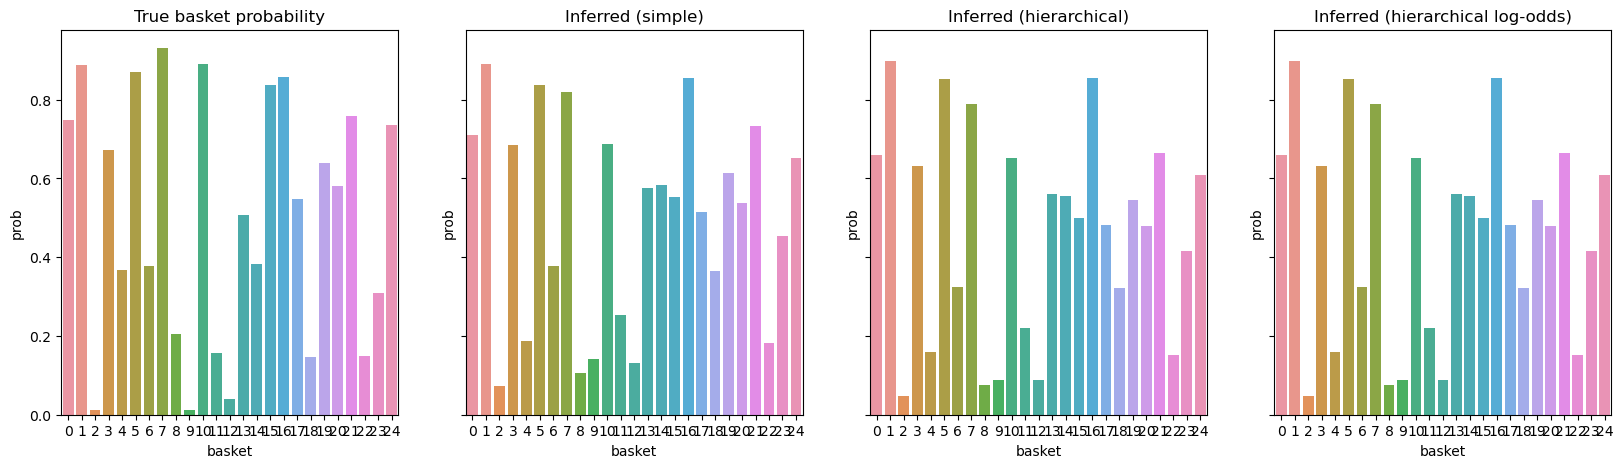

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

sns.barplot(data=true_basket_df, x='basket', y='prob', ax=ax[0])
ax[0].set_title('True basket probability')

sns.barplot(data=predicted_basket_s_df, x='basket', y='prob', ax=ax[1])
ax[1].set_title('Inferred (simple)')

sns.barplot(data=predicted_basket_h1_df, x='basket', y='prob', ax=ax[2])
ax[2].set_title('Inferred (hierarchical)')

sns.barplot(data=predicted_basket_h1_df, x='basket', y='prob', ax=ax[3])
ax[3].set_title('Inferred (hierarchical log-odds)')

Text(1452.626811594203, 0.5, 'Baskets')

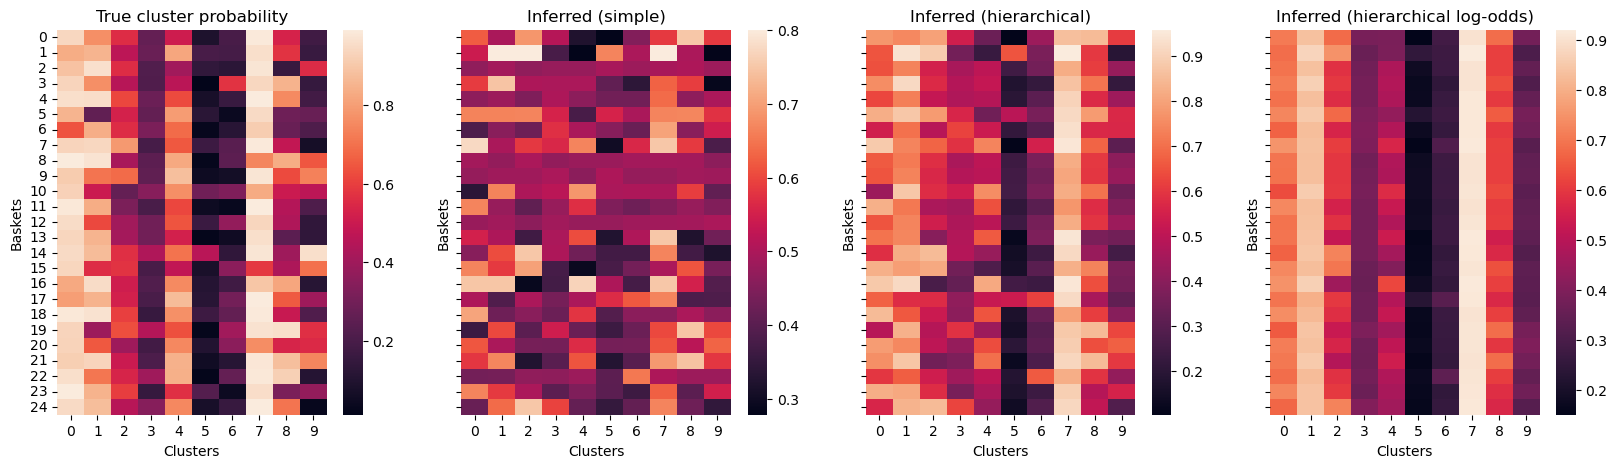

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

sns.heatmap(true_cluster_p, ax=ax[0])
ax[0].set_title('True cluster probability')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Baskets')
    
sns.heatmap(predicted_cluster_s, ax=ax[1])
ax[1].set_title('Inferred (simple)')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')
    
sns.heatmap(predicted_cluster_h1, ax=ax[2])
ax[2].set_title('Inferred (hierarchical)')
ax[2].set_xlabel('Clusters')
ax[2].set_ylabel('Baskets')
    
sns.heatmap(predicted_cluster_h2, ax=ax[3])
ax[3].set_title('Inferred (hierarchical log-odds)')
ax[3].set_xlabel('Clusters')
ax[3].set_ylabel('Baskets')

Text(1452.626811594203, 0.5, 'Baskets')

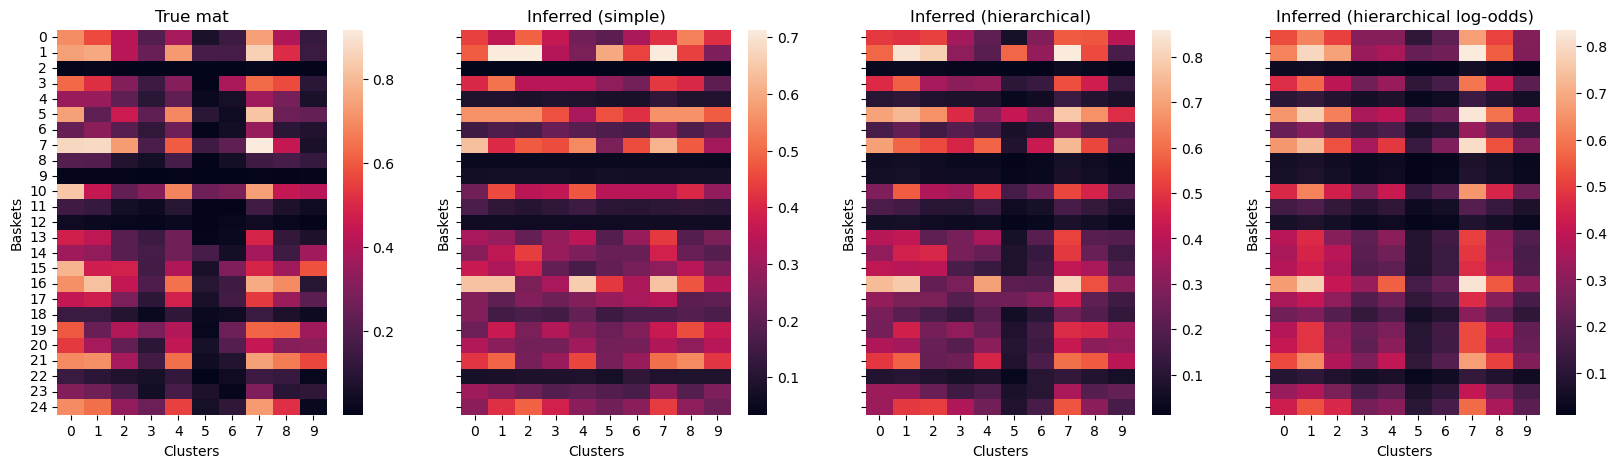

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

sns.heatmap(true_mat, ax=ax[0])
ax[0].set_title('True mat')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Baskets')
    
sns.heatmap(inferred_mat_s, ax=ax[1])
ax[1].set_title('Inferred (simple)')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')
    
sns.heatmap(inferred_mat_h1, ax=ax[2])
ax[2].set_title('Inferred (hierarchical)')
ax[2].set_xlabel('Clusters')
ax[2].set_ylabel('Baskets')
    
sns.heatmap(inferred_mat_h2, ax=ax[3])
ax[3].set_title('Inferred (hierarchical log-odds)')
ax[3].set_xlabel('Clusters')
ax[3].set_ylabel('Baskets')

Check top and bottom partitions

In [53]:
def get_indices(arr, N):
    # Get the indices of the top-3 largest values
    top_indices = np.argpartition(arr, -N, axis=None)[-N:]
    top_indices = np.unravel_index(top_indices, arr.shape)

    # Get the indices of the top-3 smallest values
    bottom_indices = np.argpartition(arr, N, axis=None)[:N]
    bottom_indices = np.unravel_index(bottom_indices, arr.shape)

    return top_indices, bottom_indices

In [54]:
def count_overlap(true_indices, inferred_indices):
    a = set(zip(true_indices[0], true_indices[1]))
    b = set(zip(inferred_indices[0], inferred_indices[1]))
    return a.intersection(b)

In [55]:
plot_data = []
for N in list(range(5, 55, 5)):

    true_top_indices, true_bottom_indices = get_indices(true_mat, N)

    inferred_top_indices_s, inferred_bottom_indices_s = get_indices(inferred_mat_s, N)
    inferred_top_indices_h1, inferred_bottom_indices_h1 = get_indices(inferred_mat_h1, N)
    inferred_top_indices_h2, inferred_bottom_indices_h2 = get_indices(inferred_mat_h2, N)

    top_overlap_s = len(count_overlap(true_top_indices, inferred_top_indices_s))
    bottom_overlap_s = len(count_overlap(true_bottom_indices, inferred_bottom_indices_s))    
    plot_data.append(['s', top_overlap_s, bottom_overlap_s, (top_overlap_s+bottom_overlap_s), N])

    top_overlap_h1 = len(count_overlap(true_top_indices, inferred_top_indices_h1))
    bottom_overlap_h1 = len(count_overlap(true_bottom_indices, inferred_bottom_indices_h1))
    plot_data.append(['h1', top_overlap_h1, bottom_overlap_h1, (top_overlap_h1+bottom_overlap_h1), N])

    top_overlap_h2 = len(count_overlap(true_top_indices, inferred_top_indices_h2))
    bottom_overlap_h2 = len(count_overlap(true_bottom_indices, inferred_bottom_indices_h2))
    plot_data.append(['h2', top_overlap_h2, bottom_overlap_h2, (top_overlap_h2+bottom_overlap_h2), N])
    
df = pd.DataFrame(plot_data, columns=['method', 'top', 'bottom', 'total', 'N'])
df

,method,top,bottom,total,N
0,s,1,0,1,5
1,h1,1,2,3,5
2,h2,2,3,5,5
3,s,6,5,11,10
4,h1,6,6,12,10
5,h2,7,7,14,10
6,s,8,8,16,15
7,h1,9,12,21,15
8,h2,12,10,22,15
9,s,10,8,18,20


Text(0.5, 1.0, 'Correct most-responsive partitions')

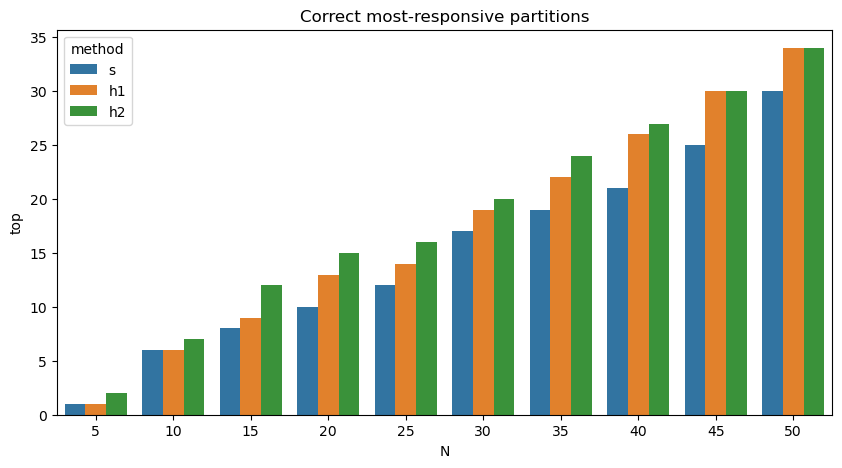

In [56]:
plt.figure(figsize=(10, 5))
sns.barplot(x='N', y='top', data=df, hue='method')
plt.title('Correct most-responsive partitions')

Text(0.5, 1.0, 'Correct least-responsive partitions')

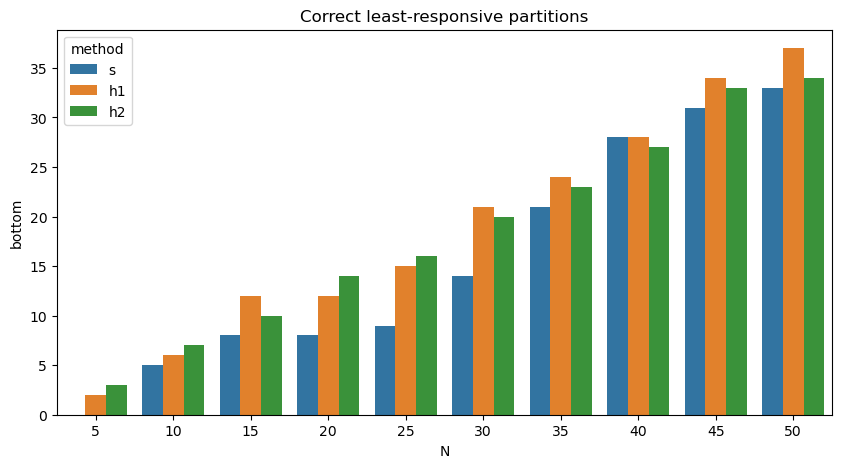

In [57]:
plt.figure(figsize=(10, 5))
sns.barplot(x='N', y='bottom', data=df, hue='method')
plt.title('Correct least-responsive partitions')

## 4. Model comparison

In [58]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="arviz.stats.stats")

In [59]:
loo_s = az.loo(trace_s)
loo_s

Computed from 20000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -259.89    11.60
p_loo       58.97        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      471   94.2%
 (0.5, 0.7]   (ok)         29    5.8%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [60]:
loo_h1 = az.loo(trace_h1)
loo_h1

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 20000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -251.78    12.55
p_loo       67.13        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      441   88.2%
 (0.5, 0.7]   (ok)         43    8.6%
   (0.7, 1]   (bad)        15    3.0%
   (1, Inf)   (very bad)    1    0.2%

In [61]:
loo_h2 = az.loo(trace_h2)
loo_h2

Computed from 20000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -242.04    12.02
p_loo       39.17        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      490   98.0%
 (0.5, 0.7]   (ok)         10    2.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [62]:
ic = 'loo'
df_comp_loo = az.compare({
    'simple': loo_s, 
    'hierarchical': loo_h1,
    'pyBasket': loo_h2,    
}, ic=ic)
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
pyBasket,0,-242.039953,39.167094,0.000000,1.000000e+00,12.023526,0.000000,False,log
hierarchical,1,-251.781801,67.131046,9.741847,0.000000e+00,12.548501,3.245034,True,log
simple,2,-259.885550,58.970155,17.845597,6.241674e-13,11.600414,5.187664,False,log


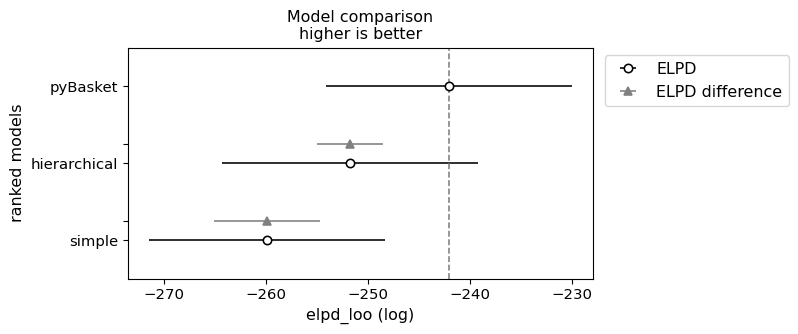

In [63]:
az.plot_compare(df_comp_loo);